# Replicating the Gürkaynak, Sack, and Wright (2006) Treasury Yield Curve

## Introduction

In this section, we'll explore how to replicate the U.S. Treasury yield curve estimation methodology developed by Gürkaynak, Sack, and Wright (2006) (hereafter GSW). The GSW yield curve has become a standard benchmark in both academic research and industry practice. Their approach provides daily estimates of the U.S. Treasury yield curve from 1961 to the present, making it an invaluable resource for analyzing historical interest rate dynamics.

## Bond Pricing from First Principles

The price of a bond is the **present value of its future cashflows**.
A Treasury note or bond makes two types of payments:

1. **Coupon payments**: Paid semiannually (every 6 months), each equal to half
   the annual coupon rate times the face value (\$100).
2. **Principal repayment**: The face value (\$100) returned at maturity.

For a bond with annual coupon rate $c$ and semiannual payment dates
$t_1, t_2, \ldots, t_N$ (where $t_N$ is the maturity date), the price is:

$$
P = \sum_{j=1}^{N-1} \frac{c}{2} \cdot d(t_j) \;+\; \left(\frac{c}{2} + 100\right) \cdot d(t_N)
$$

where $d(t)$ is the **discount factor** --- the present value today of \$1
received at time $t$. Using continuously compounded zero-coupon yields $y(t)$:

$$
d(t) = e^{-y(t) \cdot t}
$$

More compactly, if we let $CF_j$ denote the cashflow at time $t_j$:

$$
P = \sum_{j=1}^{N} CF_j \cdot d(t_j)
$$

This is just a weighted sum: each cashflow multiplied by its discount factor.

## Decomposing Bonds into Cashflows

The key insight is that **every coupon-bearing bond can be viewed as a
portfolio of zero-coupon bonds** --- one for each cashflow date. A 5-year
Treasury note with a 6% coupon is really a bundle of 10 zero-coupon
cashflows (one every 6 months) plus the principal repayment at maturity.

When we have many bonds outstanding on the same day, their cashflows land on
overlapping dates. We can organize all of this into a **cashflow matrix** $C$,
where:

- Each **row** is a bond
- Each **column** is a payment date
- Entry $C_{i,j}$ is the cashflow that bond $i$ pays on date $j$

The model-implied price vector is then a simple matrix multiplication:

$$
\mathbf{P}^{\text{model}} = C \cdot \mathbf{d}
$$

where $\mathbf{d}$ is the vector of discount factors for each payment date.
This is exactly what the code computes: `cashflows @ discount_factors`.

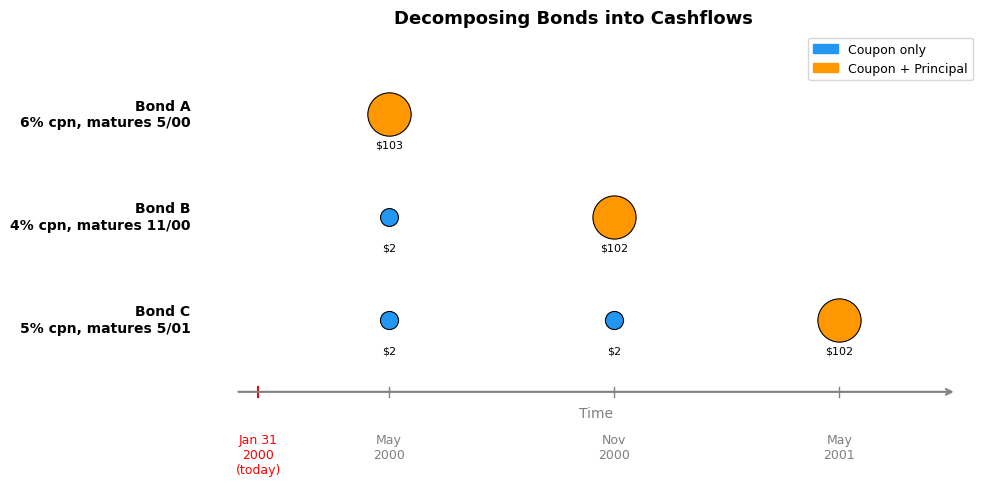

In [1]:
from plot_cashflow_diagram import plot_cashflow_diagram

plot_cashflow_diagram()

## The Identification Problem: Spot Rates are Unobserved

Here is the central challenge. To price bonds, we need the discount factors
$d(t)$, which depend on the zero-coupon yield curve $y(t)$. But **zero-coupon
yields are not directly observed** in the market.

What we *do* observe are the **prices of coupon-bearing Treasury notes and
bonds**. Each observed price is a function of *many* spot rates simultaneously
(one for each cashflow date). So the yield curve is embedded in bond prices,
but we need to extract it.

Mathematically, for $N$ bonds we observe prices $P_1, P_2, \ldots, P_N$,
and each satisfies:

$$
P_i = \sum_{j} C_{ij} \cdot d(t_j)
$$

The unknowns are the discount factors $d(t_j)$ --- or equivalently, the spot
rates $y(t_j)$ --- at every payment date. There are typically far more payment
dates than bonds, so this system is **underdetermined**. We cannot simply
"solve" for the yield curve; we need to impose some structure.

## Fitting the Spot Curve: Parametric Estimation

The solution is to assume the spot curve $y(t)$ is a smooth function described
by a small number of parameters $\theta$. Instead of estimating a separate
yield for every payment date, we search for the parameter vector $\theta$ that
best reproduces the observed bond prices.

Specifically, GSW minimize a **weighted sum of squared price errors**:

$$
\min_{\theta} \sum_{i=1}^{N} \frac{\left(P_i^{\text{obs}} - P_i^{\text{model}}(\theta)\right)^2}{D_i}
$$

where $D_i$ is the **duration** of bond $i$.

### Why weight by the inverse of duration?

Duration measures how sensitive a bond's price is to yield changes. A
long-duration bond will have larger price swings for the same yield error.
Without duration weighting, the optimizer would focus disproportionately on
matching long-duration bonds (because their price errors are naturally larger),
at the expense of short-maturity securities.

Dividing by duration approximately converts price errors into yield errors:

$$
\Delta P \approx -D \cdot \Delta y \quad \Longrightarrow \quad \frac{(\Delta P)^2}{D} \approx D \cdot (\Delta y)^2
$$

So the weighted objective treats a 1 basis point yield miss roughly the same
regardless of maturity. This gives us a yield curve that fits uniformly across
the entire term structure.

The remaining question is: **what functional form should $y(t; \theta)$ take?**
This is where the Nelson-Siegel-Svensson model comes in.

## The Nelson-Siegel-Svensson Model

The GSW methodology employs the Nelson-Siegel-Svensson (NSS) model to fit the yield curve. The NSS model expresses instantaneous forward rates using a flexible functional form with six parameters:

Example: NSS Forward Rate Function
The instantaneous forward rate n years ahead is given by:

$$
f(n) = \beta_1 + \beta_2 e^{-n/\tau_1} + \beta_3\left(\frac{n}{\tau_1}\right)e^{-n/\tau_1} + \beta_4\left(\frac{n}{\tau_2}\right)e^{-n/\tau_2}
$$


This specification allows for rich curve shapes while maintaining smoothness and asymptotic behavior. The parameters have intuitive interpretations:
- $\beta_1$: The asymptotic forward rate
- $\beta_2$, $\beta_3$, $\beta_4$: Control the shape and humps of the curve
- $\tau_1$, $\tau_2$: Determine the location of curve features

$$
y(t) = \beta_1 + \beta_2\left(\frac{1-e^{-t/\tau_1}}{t/\tau_1}\right) + \beta_3\left(\frac{1-e^{-t/\tau_1}}{t/\tau_1} - e^{-t/\tau_1}\right) + \beta_4\left(\frac{1-e^{-t/\tau_2}}{t/\tau_2} - e^{-t/\tau_2}\right)
$$

This equation shows the zero-coupon yield $y(t)$ for maturity $t$.


In [2]:
import numpy as np
import pandas as pd

import gsw2006_yield_curve
import pull_CRSP_treasury
import pull_yield_curve_data
from settings import config

DATA_DIR = config("DATA_DIR")

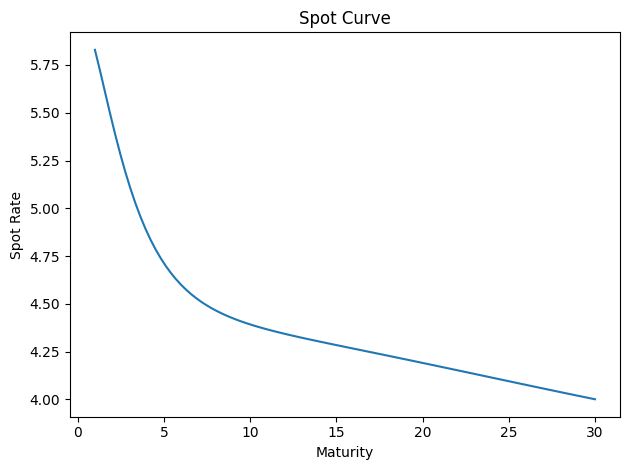

<Axes: title={'center': 'Spot Curve'}, xlabel='Maturity', ylabel='Spot Rate'>

In [3]:
# Nelson-Siegel-Svensson parameters
# "tau1", "tau2", "beta1", "beta2", "beta3", "beta4"
params = np.array([1.0, 10.0, 3.0, 3.0, 3.0, 3.0])

gsw2006_yield_curve.plot_spot_curve(params)

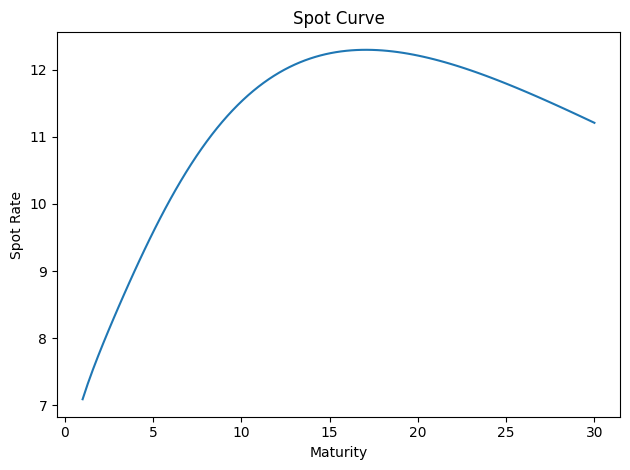

<Axes: title={'center': 'Spot Curve'}, xlabel='Maturity', ylabel='Spot Rate'>

In [4]:
# Nelson-Siegel-Svensson parameters
# "tau1", "tau2", "beta1", "beta2", "beta3", "beta4"
params = np.array([1.0, 10.0, 3.0, 3.0, 3.0, 30.0])

gsw2006_yield_curve.plot_spot_curve(params)

## Theoretical Foundations

The Nelson-Siegel-Svensson model is commonly used in practice to fit the yield curve. It has statistically appealing properties, but it is not arbitrage-free. Here's a detailed breakdown of why:


### 1. Static Curve-Fitting Approach
   - The NSS model is primarily a **parametric curve-fitting tool** that focuses on matching observed yields at a single point in time.
   - It does not model the **dynamic evolution of interest rates** or enforce consistency between short-term rate expectations and long-term yields over time, a key requirement for no-arbitrage models.

### 2. Absence of No-Arbitrage Restrictions
   - No-arbitrage models impose constraints to prevent risk-free profits. For example, affine term structure models derive bond prices from:

     $$
     P(t,T) = \mathbb{E}^\mathbb{Q}\left[e^{-\int_t^T r_s ds}\right],
     $$

     where $\mathbb{Q}$ is the risk-neutral measure. The NSS model lacks such theoretical foundations.
   - The NSS parameters (e.g., level, slope, curvature) are **statistically estimated** rather than derived from economic principles or arbitrage-free dynamics.

### 3. Factor Dynamics and Risk Premiums
   - In arbitrage-free models, factor dynamics (e.g., mean reversion) and risk premiums are explicitly defined to ensure consistency across maturities. The NSS model treats factors as **latent variables** without specifying their stochastic behavior or market price of risk.
   - This omission allows potential inconsistencies between short-rate expectations and long-term yields, creating theoretical arbitrage opportunities.

### 4. Contrast with Arbitrage-Free Extensions
   - The **arbitrage-free Nelson-Siegel (AFNS)** model, developed by Christensen et al. (2007), addresses these limitations by:
     - Embedding Nelson-Siegel factors into a dynamic arbitrage-free framework.
     - Explicitly defining factor dynamics under both physical ($\mathbb{P}$) and risk-neutral ($\mathbb{Q}$) measures.
     - Ensuring internal consistency between yields of different maturities.

### 5. Empirical vs. Theoretical Focus
   - The NSS model prioritizes **empirical flexibility** (e.g., fitting yield curve shapes like humps) over theoretical rigor. While it performs well in practice, this trade-off inherently sacrifices no-arbitrage guarantees.

In summary, the NSS model’s lack of dynamic factor specifications, absence of explicit no-arbitrage constraints, and focus on cross-sectional fitting rather than intertemporal consistency render it theoretically incompatible with arbitrage-free principles. Its successors, such as the AFNS model, bridge this gap by integrating no-arbitrage restrictions while retaining empirical tractability.


## Data Filtering

One important step of the GSW methodology is careful filtering of Treasury securities.

The following filters are implemented:

1. Exclude securities with < 3 months to maturity
2. Exclude on-the-run and first off-the-run issues after 1980
3. Exclude T-bills (only keep notes and bonds)
4. Exclude 20-year bonds after 1996 with decay
5. Exclude callable bonds

The GSW paper also includes ad hoc exclusions for specific issues, which are not implemented here.

Why are these filters important?

For (2), this is what the paper says:

> We exclude the two most recently issued securities with maturities of two,
> three, four, five, seven, ten, twenty, and thirty years for securities
> issued in 1980 or later. These are the "on-the-run" and "first off-the-run"
> issues that often trade at a premium to other Treasury securities, owing to
> their greater liquidity and their frequent specialness in the repo market.8
> Earlier in the sample, the concept of an on-the-run issue was not well
> defined, since the Treasury did not conduct regular auctions and the repo
> market was not well developed (as discussed by Garbade (2004)). Our cut-off
> point for excluding onthe- run and first off-the-run issues is somewhat
> arbitrary but is a conservative choice (in the sense of potentially erring
> on the side of being too early).

For (4), this is what the paper says:

> We begin to exclude twenty-year bonds in 1996, because those securities
> often appeared cheap relative to ten-year notes with comparable duration.
> This cheapness could reflect their lower liquidity or the fact that their
> high coupon rates made them unattractive to hold for tax-related reasons.
>
> To avoid an abrupt change to the sample, we allow their weights to linearly
> decay from 1 to 0 over the year ending on January 2, 1996.

Let's examine how we implement these filters using CRSP data. The following is
from the `pull_CRSP_treasury.py` file:

```python
def gurkaynak_sack_wright_filters(dff):
    """Apply Treasury security filters based on Gürkaynak, Sack, and Wright (2006).
    """
    df = dff.copy()

    # Filter 1: Exclude < 3 months to maturity
    df = df[df["days_to_maturity"] > 92]

    # Filter 2: Exclude on-the-run and first off-the-run after 1980
    post_1980 = df["caldt"] >= pd.to_datetime("1980-01-01")
    df = df[~(post_1980 & (df["run"] <= 2))]

    # Filter 3: Only include notes (2) and bonds (1)
    df = df[df["itype"].isin([1, 2])]

    # Filter 4: Exclude 20-year bonds after 1996 with decay
    cutoff_date = pd.to_datetime("1996-01-02")
    decay_start = cutoff_date - pd.DateOffset(years=1)

    df["weight"] = 1.0
    # Apply linear decay only during 1995-01-02 to 1996-01-02
    mask_decay = (
        (df["original_maturity"] == 20)
        & (df["caldt"] >= decay_start)
        & (df["caldt"] <= cutoff_date)
    )
    # Calculate proper decay factor for the transition year
    decay_days = (cutoff_date - decay_start).days
    decay_factor = 1 - ((df["caldt"] - decay_start).dt.days / decay_days)
    df.loc[mask_decay, "weight"] *= decay_factor

    # Completely exclude 20-year bonds after cutoff date
    mask_exclude = (df["original_maturity"] == 20) & (df["caldt"] > cutoff_date)
    df.loc[mask_exclude, "weight"] = 0

    # Filter 5: Exclude callable bonds
    df = df[~df["callable"]]

    # Remove securities with zero/negative weights
    df = df[df["weight"] > 0]

    return df

```


Let's examine how this affects the data.

In [5]:
## Load Gurkaynak Sack Wright data from Federal Reserve's website
# See here: https://www.federalreserve.gov/data/nominal-yield-curve.htm
# and here: https://www.federalreserve.gov/data/yield-curve-tables/feds200628_1.html
actual_all = pull_yield_curve_data.load_fed_yield_curve_all(data_dir=DATA_DIR)
# Create copy of parameter DataFrame to avoid view vs copy issues
actual_params_all = actual_all.loc[
    :, ["TAU1", "TAU2", "BETA0", "BETA1", "BETA2", "BETA3"]
].copy()
# Convert percentage points to decimals for beta parameters
beta_columns = ["BETA0", "BETA1", "BETA2", "BETA3"]
actual_params_all[beta_columns] = actual_params_all[beta_columns] / 100


## Load CRSP Treasury data from Wharton Research Data Services
# We will fit a Nelson-Siegel-Svensson model to this data to see
# if we can replicate the Gurkaynak Sack Wright results above.
df_all = pull_CRSP_treasury.load_CRSP_treasury_consolidated(data_dir=DATA_DIR)

In [6]:
describe_cols = ["price", "tcouprt", "years_to_maturity", "tdduratn"]
df_all[describe_cols].describe()

,price,tcouprt,years_to_maturity,tdduratn
count,2.530548e+06,2.530592e+06,2.530592e+06,2.530592e+06
mean,1.057161e+02,5.372427e+00,6.223965e+00,1.658160e+03
std,1.351318e+01,3.557650e+00,7.416524e+00,1.639392e+03
min,4.405673e+01,1.250000e-01,0.000000e+00,-1.000000e+00
25%,9.979416e+01,2.375000e+00,1.000000e+00,5.116591e+02
50%,1.022880e+02,4.750000e+00,3.000000e+00,1.114021e+03
75%,1.081889e+02,7.875000e+00,7.000000e+00,2.164954e+03
max,1.827193e+02,1.625000e+01,3.000000e+01,9.160067e+03


In [7]:
df_all = gsw2006_yield_curve.gurkaynak_sack_wright_filters(df_all)
df_all[describe_cols].describe()

,price,tcouprt,years_to_maturity,tdduratn
count,2.120639e+06,2.120645e+06,2.120645e+06,2.120645e+06
mean,1.060708e+02,5.240046e+00,6.125277e+00,1.651092e+03
std,1.379746e+01,3.470534e+00,7.224184e+00,1.612092e+03
min,4.405673e+01,1.250000e-01,0.000000e+00,-1.000000e+00
25%,9.976197e+01,2.250000e+00,1.000000e+00,5.223430e+02
50%,1.025367e+02,4.625000e+00,3.000000e+00,1.115093e+03
75%,1.087744e+02,7.750000e+00,7.000000e+00,2.102661e+03
max,1.827193e+02,1.625000e+01,2.900000e+01,8.738464e+03


## Implementation Steps

### 1. Data Preparation
First, we load and clean the CRSP Treasury data

In [8]:
df_all = pull_CRSP_treasury.load_CRSP_treasury_consolidated(data_dir=DATA_DIR)

### 2. Cashflow Construction
For each Treasury security, we need to calculate its future cashflows. Consider the following simplified example:


In [9]:
sample_data = pd.DataFrame(
    {
        "tcusip": ["A", "B", "C", "D", "E"],
        "tmatdt": pd.to_datetime(
            ["2000-05-15", "2000-05-31", "2000-06-30", "2000-07-31", "2000-08-15"]
        ),
        "price": [101, 101, 100, 100, 103],
        "tcouprt": [6, 6, 0, 5, 6],
        "caldt": pd.to_datetime("2000-01-31"),
    }
)

cashflow = gsw2006_yield_curve.calc_cashflows(sample_data)

# Treasury securities have 2 coupon payments per year
# and pay their final coupon and principal on the maturity date
expected_cashflow = np.array(
    [
        [0.0, 103.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 103.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 100.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 102.5, 0.0],
        [3.0, 0.0, 0.0, 0.0, 0.0, 103.0],
    ]
)

In [10]:
cashflow

,2000-02-15,2000-05-15,2000-05-31,2000-06-30,2000-07-31,2000-08-15
0,0.0,103.0,0.0,0.0,0.0,0.0
1,0.0,0.0,103.0,0.0,0.0,0.0
2,0.0,0.0,0.0,100.0,0.0,0.0
3,0.0,0.0,0.0,0.0,102.5,0.0
4,3.0,0.0,0.0,0.0,0.0,103.0


### 3. Model Fitting
The NSS model is fit by minimizing price errors weighted by duration:

$$
\min_{\beta,\tau} \sum_{i=1}^N \frac{(P_i^{obs} - P_i^{model})^2}{D_i}
$$

where:
- $P_i^{obs}$ = Observed clean price (including accrued interest)
- $P_i^{model}$ = Model-implied price
- $D_i$ = Duration of security i

Now, why are the squared errors weighted by the duration?

Recall that bond duration is a measurement of how much a bond's price will change in response to interest rate changes.
Thus, the price error objective is approximately equivalent to minimizing unweighted yield errors:

$$
\frac{(P_i^{obs} - P_i^{model})^2}{D_i} \approx D_i \cdot (y_i^{obs} - y_i^{model})^2
$$

This approximation comes from the duration relationship:

$$
P^{obs} - P^{model} \approx -D \cdot (y^{obs} - y^{model})
$$

Making the objective function:

$$
\sum D_i \cdot (y_i^{obs} - y_i^{model})^2
$$

So, why Price Errors Instead of Yield Errors?

1. **Non-linear relationship**: The price/yield relationship is convex
    (convexity adjustment matters more for long-duration bonds)
2. **Coupon effects**: Directly accounts for differential cash flow timing
3. **Numerical stability**: Prices have linear sensitivity to parameters via
    discount factors, while yields require non-linear root-finding
4. **Economic meaning**: Aligns with trader behavior that thinks in terms of
    price arbitrage

Reference: Gurkaynak, Sack, and Wright (2006)

### Note

Note that the paper says the following:

> In estimating the yield curve, we choose the parameters to minimize the weighted
> sum of the squared deviations between the actual prices of Treasury securities and the
> predicted prices. The weights chosen are the inverse of the duration of each individual
> security. To a rough approximation, the deviation between the actual and predicted
> prices of an individual security will equal its duration multiplied by the deviation
> between the actual and predicted yields. Thus, this procedure is approximately equal to
> minimizing the (unweighted) sum of the squared deviations between the actual and
> predicted yields on all of the securities.

However, I need to check this further since it initially seems to me that this procedure is minimizing the squared yield errors, weighted by the duration. However, the fit to actual prices seems better with the procedure above. I need to check this further.


## Testing and Validation

To validate our implementation, we compare our fitted yields against the official GSW yields published by the Federal Reserve:


In [11]:

## Load Gurkaynak Sack Wright data from Federal Reserve's website
# See here: https://www.federalreserve.gov/data/nominal-yield-curve.htm
# and here: https://www.federalreserve.gov/data/yield-curve-tables/feds200628_1.html
actual_all = pull_yield_curve_data.load_fed_yield_curve_all(data_dir=DATA_DIR)
# Create copy of parameter DataFrame to avoid view vs copy issues
actual_params_all = actual_all.loc[
    :, ["TAU1", "TAU2", "BETA0", "BETA1", "BETA2", "BETA3"]
].copy()
# Convert percentage points to decimals for beta parameters
beta_columns = ["BETA0", "BETA1", "BETA2", "BETA3"]
actual_params_all[beta_columns] = actual_params_all[beta_columns] / 100


## Load CRSP Treasury data from Wharton Research Data Services
# We will fit a Nelson-Siegel-Svensson model to this data to see
# if we can replicate the Gurkaynak Sack Wright results above.
df_all = pull_CRSP_treasury.load_CRSP_treasury_consolidated(data_dir=DATA_DIR)
df_all = gsw2006_yield_curve.gurkaynak_sack_wright_filters(df_all)

In [12]:
quote_dates = pd.date_range("2000-01-02", "2024-06-30", freq="BMS")
# quote_date = quote_dates[-1]

## Test Day 1
quote_date = pd.to_datetime("2024-06-03")
# Subset df_all to quote_date
df = df_all[df_all["caldt"] == quote_date]
actual_params = actual_params_all[actual_params_all.index == quote_date].values[0]

# "tau1", "tau2", "beta1", "beta2", "beta3", "beta4"
# params0 = np.array([1.0, 10.0, 3.0, 3.0, 3.0, 3.0])
params0 = np.array([0.989721, 9.955324, 3.685087, 1.579927, 3.637107, 9.814584])
# params0 = np.array([1.0, 1.0, 0.001, 0.001, 0.001, 0.001])

params_star, error = gsw2006_yield_curve.fit(quote_date, df_all, params0)

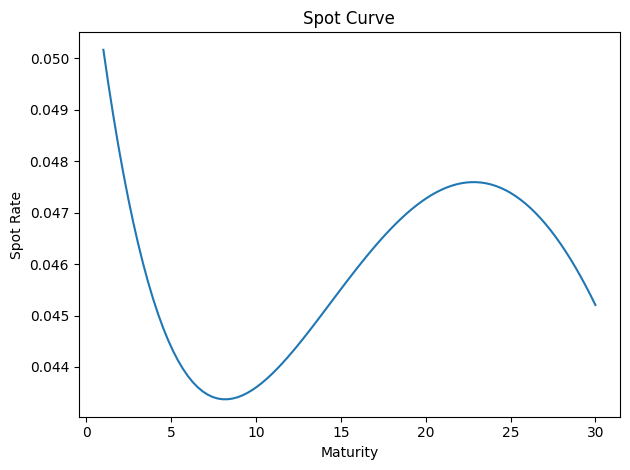

<Axes: title={'center': 'Spot Curve'}, xlabel='Maturity', ylabel='Spot Rate'>

In [13]:
## Visualize the fit
gsw2006_yield_curve.plot_spot_curve(params_star)

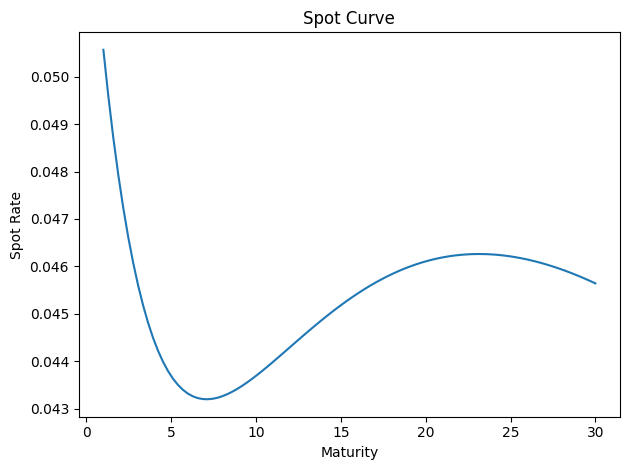

<Axes: title={'center': 'Spot Curve'}, xlabel='Maturity', ylabel='Spot Rate'>

In [14]:
gsw2006_yield_curve.plot_spot_curve(actual_params)

In [15]:
price_comparison = gsw2006_yield_curve.compare_fit(
    quote_date, df_all, params_star, actual_params, df
)
price_comparison

,Actual Price,GSW Predicted Price,Model Predicted Price,Predicted - Actual %,Predicted - GSW %
tcusip,,,,,
912810ET,104.189560,103.877734,103.934239,-0.002451,0.000544
912810EV,104.504035,104.146501,104.169835,-0.003198,0.000224
912810EW,103.835766,103.539602,103.500204,-0.003232,-0.000381
912810EX,106.232229,106.071133,105.960397,-0.002559,-0.001044
912810EY,105.202785,104.356538,104.209598,-0.009441,-0.001408
...,...,...,...,...,...
91282CJW,99.132169,99.440209,99.129604,-0.000026,-0.003124
91282CJX,98.413419,99.124083,98.902013,0.004965,-0.002240
91282CKB,100.744735,100.757545,100.712789,-0.000317,-0.000444


In [16]:
## Assert that column is close to 0 for all CUSIPs
assert (price_comparison["Predicted - Actual %"].abs() < 0.05).all()
assert (price_comparison["Predicted - GSW %"].abs() < 0.02).all()

In [17]:

## Test Day 2
quote_date = pd.to_datetime("2000-06-05")
# Subset df_all to quote_date
df = df_all[df_all["caldt"] == quote_date]
actual_params = actual_params_all[actual_params_all.index == quote_date].values[0]

# "tau1", "tau2", "beta1", "beta2", "beta3", "beta4"
# params0 = np.array([1.0, 10.0, 3.0, 3.0, 3.0, 3.0])
params0 = np.array([0.989721, 9.955324, 3.685087, 1.579927, 3.637107, 9.814584])
# params0 = np.array([1.0, 1.0, 0.001, 0.001, 0.001, 0.001])

params_star, error = gsw2006_yield_curve.fit(quote_date, df_all, params0)

## Visualize the fit
# gsw2006_yield_curve.plot_spot_curve(params_star)
# gsw2006_yield_curve.plot_spot_curve(actual_params)

price_comparison = gsw2006_yield_curve.compare_fit(
    quote_date, df_all, params_star, actual_params, df
)

## Assert that column is close to 0 for all CUSIPs
assert (price_comparison["Predicted - Actual %"].abs() < 0.05).all()
assert (price_comparison["Predicted - GSW %"].abs() < 0.02).all()

In [18]:
## Test Day 3
quote_date = pd.to_datetime("1990-06-05")
# Subset df_all to quote_date
df = df_all[df_all["caldt"] == quote_date]
actual_params = actual_params_all[actual_params_all.index == quote_date].values[0]

# "tau1", "tau2", "beta1", "beta2", "beta3", "beta4"
# params0 = np.array([1.0, 10.0, 3.0, 3.0, 3.0, 3.0])
params0 = np.array([0.989721, 9.955324, 3.685087, 1.579927, 3.637107, 9.814584])
# params0 = np.array([1.0, 1.0, 0.001, 0.001, 0.001, 0.001])

params_star, error = gsw2006_yield_curve.fit(quote_date, df_all, params0)

## Visualize the fit
# gsw2006_yield_curve.plot_spot_curve(params_star)
# gsw2006_yield_curve.plot_spot_curve(actual_params)

price_comparison = gsw2006_yield_curve.compare_fit(
    quote_date, df_all, params_star, actual_params, df
)

## Assert that column is close to 0 for all CUSIPs
assert (price_comparison["Predicted - Actual %"].abs() < 0.05).all()
assert (price_comparison["Predicted - GSW %"].abs() < 0.02).all()

## Application: Identifying Rich and Cheap Bonds

Now that we have a fitted yield curve, we can use it for a practical
application: **identifying mispriced bonds**.

The idea is simple. The fitted NSS yield curve defines a smooth relationship
between maturity and discount rates. Given this curve, we can compute a
**model-implied price** for every bond. The difference between a bond's
actual market price and its model price is the **pricing error**:

$$
\text{Pricing Error}_i = P_i^{\text{actual}} - P_i^{\text{model}}
$$

- If $P_i^{\text{actual}} > P_i^{\text{model}}$, the bond trades
  **above** the model price. Traders call this **"rich"** (overpriced).
- If $P_i^{\text{actual}} < P_i^{\text{model}}$, the bond trades
  **below** the model price. Traders call this **"cheap"** (underpriced).

We can also express this as a percentage of the model price:

$$
\text{Pricing Error %}_i = \frac{P_i^{\text{actual}} - P_i^{\text{model}}}{P_i^{\text{model}}} \times 100
$$

### Why do pricing errors arise?

The fitted yield curve is a smooth parametric function with only 6
parameters. It cannot perfectly match every bond's price. The residual
pricing errors can reflect:

1. **Liquidity differences** --- some bonds are more actively traded
2. **Supply/demand imbalances** --- certain maturities may be in higher demand
3. **Specialness in the repo market** --- bonds that are "special" trade at a premium
4. **Tax effects** --- high-coupon bonds may be less desirable for tax reasons
5. **Model limitations** --- the NSS form cannot capture every pricing nuance

Identifying rich and cheap bonds is a starting point for **relative value
trading** strategies in fixed income.

In [19]:
## Find the most recent date available in both datasets
available_dates = set(df_all["caldt"].unique())
gsw_dates = set(actual_params_all.index)
common_dates = sorted(available_dates & gsw_dates)
quote_date = pd.to_datetime(common_dates[-1])
print(f"Analysis date: {quote_date.strftime('%Y-%m-%d')}")

## Subset data for this date
df = df_all[df_all["caldt"] == quote_date].copy()
print(f"Number of bonds in sample: {len(df)}")

## Use Fed's published GSW parameters as initial guess for fast convergence
actual_params = actual_params_all.loc[quote_date].values
params_star, error = gsw2006_yield_curve.fit(quote_date, df_all, params0=actual_params)

## Compute model-predicted prices for all bonds on this date
predicted_prices = gsw2006_yield_curve.predict_prices(quote_date, df_all, params_star)

## Build the analysis table
actual_prices = df.set_index("tcusip")["price"]
pricing_error = actual_prices - predicted_prices
pricing_error_pct = (pricing_error / predicted_prices) * 100

bond_info = df.set_index("tcusip")[["tcouprt", "tmatdt", "itype", "days_to_maturity", "original_maturity"]]
rich_cheap = pd.DataFrame({
    "Actual Price": actual_prices.round(4),
    "Model Price": predicted_prices.round(4),
    "Error ($)": pricing_error.round(4),
    "Error (%)": pricing_error_pct.round(4),
    "Coupon (%)": bond_info["tcouprt"],
    "Maturity": bond_info["tmatdt"].dt.strftime("%Y-%m-%d"),
    "Orig Mat (Yrs)": bond_info["original_maturity"].astype(int),
    "Yrs to Mat": (bond_info["days_to_maturity"] / 365.25).round(1),
    "Type": bond_info["itype"].map({1: "Bond", 2: "Note"}),
})
rich_cheap.index.name = "CUSIP"

Analysis date: 2025-12-31
Number of bonds in sample: 294


### By Dollar Error

In [20]:
## Top 5 RICH (overpriced) bonds by dollar error
rich_cheap.nlargest(5, "Error ($)")

,Actual Price,Model Price,Error ($),Error (%),Coupon (%),Maturity,Orig Mat (Yrs),Yrs to Mat,Type
CUSIP,,,,,,,,,
912810PW,102.5781,101.4973,1.0808,1.0648,4.375,2038-02-15,30,12.1,Bond
912810FT,104.9492,103.8898,1.0594,1.0197,4.500,2036-02-15,30,10.1,Bond
912810PU,107.7096,106.6694,1.0402,0.9751,5.000,2037-05-15,30,11.4,Bond
912810PX,102.5054,101.4778,1.0277,1.0127,4.500,2038-05-15,30,12.4,Bond
912810PT,106.5801,105.6450,0.9351,0.8851,4.750,2037-02-15,30,11.1,Bond


In [21]:
## Top 5 CHEAP (underpriced) bonds by dollar error
rich_cheap.nsmallest(5, "Error ($)")

,Actual Price,Model Price,Error ($),Error (%),Coupon (%),Maturity,Orig Mat (Yrs),Yrs to Mat,Type
CUSIP,,,,,,,,,
912810RE,87.2383,87.9609,-0.7226,-0.8215,3.625,2044-02-15,30,18.1,Bond
912810RC,87.7109,88.4228,-0.7118,-0.8050,3.625,2043-08-15,30,17.6,Bond
912810RD,88.1445,88.8442,-0.6997,-0.7876,3.750,2043-11-15,30,17.9,Bond
912810RG,82.9914,83.6820,-0.6907,-0.8253,3.375,2044-05-15,30,18.4,Bond
912810RH,80.3516,81.0231,-0.6716,-0.8288,3.125,2044-08-15,30,18.6,Bond


### By Percent Error

In [22]:
## Top 5 RICH (overpriced) bonds by percent error
rich_cheap.nlargest(5, "Error (%)")

,Actual Price,Model Price,Error ($),Error (%),Coupon (%),Maturity,Orig Mat (Yrs),Yrs to Mat,Type
CUSIP,,,,,,,,,
912810PW,102.5781,101.4973,1.0808,1.0648,4.375,2038-02-15,30,12.1,Bond
912810SN,48.0612,47.5639,0.4972,1.0454,1.250,2050-05-15,30,24.4,Bond
912810FT,104.9492,103.8898,1.0594,1.0197,4.500,2036-02-15,30,10.1,Bond
912810PX,102.5054,101.4778,1.0277,1.0127,4.500,2038-05-15,30,12.4,Bond
912810PU,107.7096,106.6694,1.0402,0.9751,5.000,2037-05-15,30,11.4,Bond


In [23]:
## Top 5 CHEAP (underpriced) bonds by percent error
rich_cheap.nsmallest(5, "Error (%)")

,Actual Price,Model Price,Error ($),Error (%),Coupon (%),Maturity,Orig Mat (Yrs),Yrs to Mat,Type
CUSIP,,,,,,,,,
912810RH,80.3516,81.0231,-0.6716,-0.8288,3.125,2044-08-15,30,18.6,Bond
912810RG,82.9914,83.6820,-0.6907,-0.8253,3.375,2044-05-15,30,18.4,Bond
912810RE,87.2383,87.9609,-0.7226,-0.8215,3.625,2044-02-15,30,18.1,Bond
912810RC,87.7109,88.4228,-0.7118,-0.8050,3.625,2043-08-15,30,17.6,Bond
912810RJ,77.7484,78.3699,-0.6215,-0.7930,3.000,2044-11-15,30,18.9,Bond


### Interpreting the Results

A few things to keep in mind:

1. **Small errors are expected.** The GSW model fits the cross-section of
   bond prices very well. Typical pricing errors are a few cents per \$100
   of face value.

2. **Rich $\neq$ bad investment.** A bond may trade rich because it has
   superior liquidity, is in high demand as collateral, or has favorable
   tax treatment. The "richness" may be justified by these factors.

3. **Cheap $\neq$ free lunch.** A bond that appears cheap relative to the
   model may have lower liquidity or other undesirable characteristics.

4. **The model is a simplification.** The NSS yield curve uses only 6
   parameters to describe the entire term structure. Any individual bond's
   pricing error reflects both genuine mispricing *and* model approximation
   error.

5. **Relative value in practice.** Traders use this type of analysis as a
   *starting point*. A bond flagged as cheap would then be examined more
   carefully --- checking its repo rate, recent trading volume, and
   comparison to close substitutes --- before any trade is executed.